# MSCDSBA2030: Reinforcement Learning - Text Flappy Bird

**Student Name:** Dorian Boucher

## 1. Introduction

This notebook implements and compares two Reinforcement Learning (RL) agents, Monte Carlo and Sarsa(λ), to solve the Text Flappy Bird game[cite: 1, 7]. The goal is to train agents to play the game effectively using the `TextFlappyBird-v0` environment, which provides the player's distance to the next pipe gap as observations[cite: 5, 6].

We will:
1. Set up the environment.
2. Implement a Monte Carlo based agent.
3. Implement the Sarsa(λ) agent.
4. Train both agents and evaluate their performance.
5. Analyze and compare the results, including convergence, parameter sensitivity, and state-value functions[cite: 10, 12].
6. Discuss the findings and limitations[cite: 11, 14, 15, 16].

**Environment Reference:** [Text Flappy Bird Gym](https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym) [cite: 4]


## 2. Setup and Environment Exploration

First, let's install the necessary libraries and the custom Gym environment.

In [3]:
# %%
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from collections import defaultdict
import random
from tqdm.notebook import tqdm
import time

### 2.1. Initialize Environment

We'll use the `TextFlappyBird-v0` environment. This version provides observations as `(horizontal_distance, vertical_distance)` to the center of the next pipe gap[cite: 5]. Let's initialize it and examine its properties.


In [4]:
# Initialize the environment with specified parameters (e.g., height, width, pipe_gap)
env_params = {'height': 15, 'width': 20, 'pipe_gap': 4}
env = gym.make('TextFlappyBird-v0', **env_params)

# Print environment details
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

# Access properties of the individual spaces within the Tuple
if isinstance(env.observation_space, gym.spaces.Tuple):
    print("Observation space details:")
    space1 = env.observation_space.spaces[0]
    space2 = env.observation_space.spaces[1]
    print(f"  - Horizontal Distance Space: {space1}")
    print(f"    - Size (n): {space1.n}")
    print(f"    - Start: {getattr(space1, 'start', 0)}") # Discrete spaces default start=0
    print(f"  - Vertical Distance Space: {space2}")
    print(f"    - Size (n): {space2.n}")
    print(f"    - Start: {getattr(space2, 'start', 0)}")
    # Store these for later use if needed
    h_dist_space = space1
    v_dist_space = space2
else:
    print("Observation space is not a Tuple as expected.")
    # Add handling for other space types if necessary
    h_dist_space = None
    v_dist_space = None


# Reset environment and get initial observation
obs, info = env.reset()
print(f"Initial Observation (raw): {obs}")

Action Space: Discrete(2)
Observation Space: Tuple(Discrete(14), Discrete(22, start=-11))
Observation space details:
  - Horizontal Distance Space: Discrete(14)
    - Size (n): 14
    - Start: 0
  - Vertical Distance Space: Discrete(22, start=-11)
    - Size (n): 22
    - Start: -11
Initial Observation (raw): (13, 4)


In [5]:
# The state is simply the observation tuple.
def get_state(observation):
    """Returns the state representation from the observation."""
    # In this case, the observation IS the state for tabular methods.
    return tuple(observation)

# Example state representation
initial_state = get_state(obs)
print(f"Initial Observation: {obs}")
print(f"Initial State Representation: {initial_state}")

# Calculate total number of states if needed (useful for understanding complexity)
if h_dist_space and v_dist_space:
    total_states = h_dist_space.n * v_dist_space.n
    print(f"Total number of discrete states: {h_dist_space.n} * {v_dist_space.n} = {total_states}")
else:
    total_states = None
    print("Could not determine total number of states.")

Initial Observation: (13, 4)
Initial State Representation: (13, 4)
Total number of discrete states: 14 * 22 = 308


### 2.3. Helper Functions

Define helper functions for epsilon-greedy policy and plotting. The plotting function needs adjustment if we want to visualize the V-function based on the discrete state indices.


In [6]:
def epsilon_greedy_policy(Q, state, epsilon, action_space):
    """Selects an action using an epsilon-greedy policy."""
    if random.random() < epsilon:
        return action_space.sample()  # Explore
    else:
        # Exploit: Choose the action with the highest Q-value
        # Handle ties by choosing randomly among the best actions
        q_values = Q.get(state, {}) # Use .get for states not yet visited
        if not q_values: # If state hasn't been seen or no actions have values
             return action_space.sample()

        max_q = max(q_values.values())
        best_actions = [action for action, q in q_values.items() if q == max_q]
        return random.choice(best_actions)

def plot_rewards(episode_rewards, title="Training Rewards"):
    """Plots the rewards obtained per episode."""
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()

def plot_state_value_function(Q, h_space, v_space, title="State-Value Function (V*)"):
    """Visualizes the estimated state-value function V(s) = max_a Q(s,a)."""
    if not h_space or not v_space:
        print("Cannot plot state-value function without space info.")
        return None

    h_n = h_space.n
    v_n = v_space.n
    v_start = getattr(v_space, 'start', 0)

    V = np.zeros((h_n, v_n)) # Dimensions based on Discrete space sizes

    for h_idx in range(h_n):
        for v_idx_offset in range(v_n):
            v_idx = v_start + v_idx_offset # Actual vertical index value
            state = (h_idx, v_idx)
            q_values = Q.get(state, {})
            max_q = 0
            if q_values: # Check if the dictionary is not empty
                max_q = max(q_values.values())
            # Store in the V array using 0-based index for plotting
            V[h_idx, v_idx_offset] = max_q

    plt.figure(figsize=(max(8, h_n // 2), max(6, v_n // 2))) # Adjust size based on state space
    plt.imshow(V.T, origin='lower', cmap='viridis', aspect='auto',
               extent=[0, h_n, v_start, v_start + v_n]) # Use actual value ranges for extent
    plt.colorbar(label='State Value (V*)')
    plt.title(title)
    plt.xlabel(f"Horizontal Distance Index (0 to {h_n-1})")
    plt.ylabel(f"Vertical Distance Index ({v_start} to {v_start + v_n - 1})")
    plt.xticks(np.arange(h_n + 1))
    plt.yticks(np.arange(v_start, v_start + v_n + 1))
    plt.grid(True, which='both', color='grey', linewidth=0.5)
    plt.show()
    return V

## 3. Agent 1: Monte Carlo Method

Implement On-Policy First-Visit MC Control. The state representation is now the direct observation tuple.


In [7]:
def run_monte_carlo(env, num_episodes, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    """Trains an agent using On-Policy First-Visit Monte Carlo Control with tqdm progress."""
    Q = defaultdict(lambda: defaultdict(float)) # Q[state][action]
    Returns = defaultdict(lambda: defaultdict(list)) # Returns[state][action]
    action_space = env.action_space
    epsilon = epsilon_start
    episode_rewards = []
    episode_scores = [] # Track game scores

    # Wrap the episode loop with tqdm
    pbar = tqdm(range(num_episodes), desc="Training MC", unit="ep")
    for episode in pbar:
        # Generate an episode
        episode_data = []
        observation, info = env.reset()
        state = get_state(observation) # Use the new state function
        done = False
        current_episode_reward = 0
        current_episode_score = 0
        steps = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, action_space)
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state = get_state(next_observation) # Use the new state function

            episode_data.append((state, action, reward))
            current_episode_reward += reward
            current_episode_score = info.get('score', 0) # Get score from info dict
            steps += 1
            state = next_state

        episode_rewards.append(current_episode_reward)
        episode_scores.append(current_episode_score)

        # Update Q-values (First-Visit MC)
        G = 0
        visited_state_action_pairs = set()
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward
            state_action = (state, action)

            # Use tuple state directly as key
            if state_action not in visited_state_action_pairs:
                Returns[state][action].append(G)
                Q[state][action] = np.mean(Returns[state][action])
                visited_state_action_pairs.add(state_action)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Update tqdm progress bar postfix with relevant info (e.g., every 10 episodes)
        if (episode + 1) % 10 == 0:
             avg_reward_last_100 = np.mean(episode_rewards[-100:])
             avg_score_last_100 = np.mean(episode_scores[-100:])
             pbar.set_postfix({
                 "Avg R (100)": f"{avg_reward_last_100:.2f}",
                 "Avg S (100)": f"{avg_score_last_100:.2f}",
                 "Epsilon": f"{epsilon:.3f}",
                 "Steps": steps # Steps in the last episode
             })

    pbar.close() # Close the progress bar explicitly
    print(f"Monte Carlo training finished. Final Avg Score (last 100 ep): {np.mean(episode_scores[-100:]):.2f}")
    return Q, episode_rewards, episode_scores

### 3.1. Train Monte Carlo Agent

In [8]:
# Parameters for Monte Carlo
mc_episodes = 10000 # Adjust as needed
mc_gamma = 0.99
mc_epsilon_start = 1.0
mc_epsilon_decay = 0.9995 # Slower decay might be needed
mc_epsilon_min = 0.05

# Run training
mc_Q, mc_rewards, mc_scores = run_monte_carlo(env, mc_episodes, mc_gamma, mc_epsilon_start, mc_epsilon_decay, mc_epsilon_min)

Training MC:   0%|          | 0/10000 [00:00<?, ?ep/s]

Monte Carlo training finished. Final Avg Score (last 100 ep): 11.14


### 3.2. Analyze Monte Carlo Results

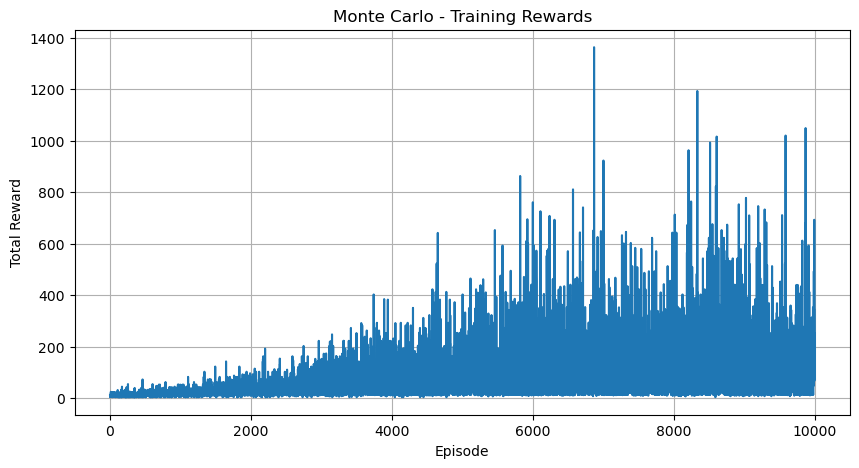

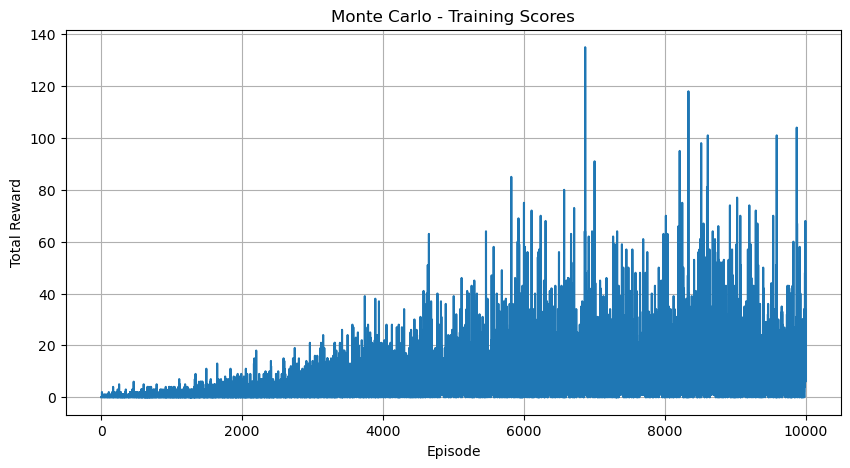

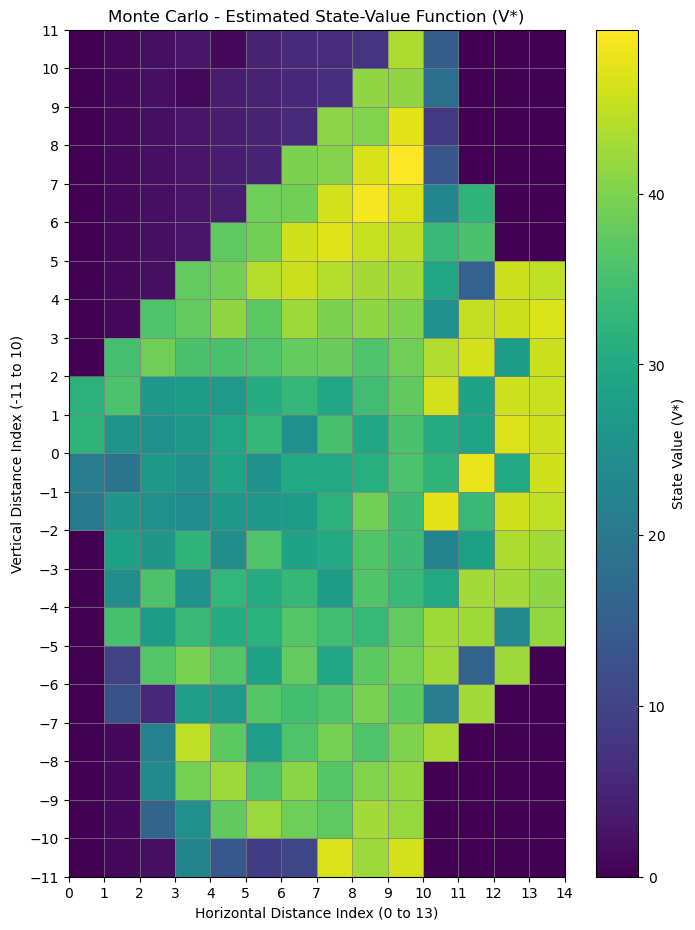

In [9]:
plot_rewards(mc_rewards, title="Monte Carlo - Training Rewards")
plot_rewards(mc_scores, title="Monte Carlo - Training Scores")

# Plot State-Value Function
mc_V = plot_state_value_function(mc_Q, h_dist_space, v_dist_space, title="Monte Carlo - Estimated State-Value Function (V*)")


## 4. Agent 2: Sarsa(λ)

Implement Sarsa(λ) using eligibility traces. State representation is the direct observation tuple.

In [11]:
def run_sarsa_lambda(env, num_episodes, alpha=0.1, gamma=0.99, lambda_trace=0.9, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.01):
    """Trains an agent using Sarsa(Lambda) with eligibility traces and tqdm progress."""
    Q = defaultdict(lambda: defaultdict(float)) # Q[state][action]
    action_space = env.action_space
    epsilon = epsilon_start
    episode_rewards = []
    episode_scores = []

    # Wrap the episode loop with tqdm
    pbar = tqdm(range(num_episodes), desc=f"Training Sarsa(λ α={alpha}, λ={lambda_trace})", unit="ep")
    for episode in pbar:
        E = defaultdict(lambda: defaultdict(float)) # Eligibility traces E[state][action]
        observation, info = env.reset()
        state = get_state(observation) # Use new state function
        action = epsilon_greedy_policy(Q, state, epsilon, action_space)
        done = False
        current_episode_reward = 0
        current_episode_score = 0
        steps = 0

        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state = get_state(next_observation) # Use new state function

            # Choose next action A' based on next_state S'
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, action_space) if not done else 0 # Default action if terminal

            # Calculate TD error (delta)
            q_next_state_action = Q.get(next_state, {}).get(next_action, 0.0)
            td_target = reward + (gamma * q_next_state_action if not done else 0)
            q_state_action = Q.get(state, {}).get(action, 0.0)
            td_error = td_target - q_state_action

            # Update eligibility trace
            E[state][action] += 1

            # Update Q-values and decay traces
            for s_trace in list(E.keys()):
                 for a_trace in list(E[s_trace].keys()):
                     Q[s_trace][a_trace] += alpha * td_error * E[s_trace][a_trace]
                     E[s_trace][a_trace] *= gamma * lambda_trace
                     # Optional pruning can be added here

            current_episode_reward += reward
            current_episode_score = info.get('score', 0)
            steps += 1

            # Move to next state
            state = next_state
            action = next_action

        episode_rewards.append(current_episode_reward)
        episode_scores.append(current_episode_score)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Update tqdm progress bar postfix
        if (episode + 1) % 100 == 0:
            avg_reward_last_100 = np.mean(episode_rewards[-100:])
            avg_score_last_100 = np.mean(episode_scores[-100:])
            pbar.set_postfix({
                "Avg R (100)": f"{avg_reward_last_100:.2f}",
                "Avg S (100)": f"{avg_score_last_100:.2f}",
                "Epsilon": f"{epsilon:.3f}",
                "Steps": steps,
                "Traces": len(E) # Number of states with active traces
            })

    pbar.close() # Close the progress bar explicitly
    print(f"Sarsa(Lambda α={alpha}, λ={lambda_trace}) training finished. Final Avg Score (last 100 ep): {np.mean(episode_scores[-100:]):.2f}")
    return Q, episode_rewards, episode_scores

### 4.1. Train Sarsa(λ) Agent

In [12]:
# Parameters for Sarsa(Lambda)
sarsa_episodes = 10000 # Adjust as needed
sarsa_alpha = 0.1      # Learning rate
sarsa_gamma = 0.99
sarsa_lambda = 0.9     # Trace decay parameter
sarsa_epsilon_start = 1.0
sarsa_epsilon_decay = 0.9995
sarsa_epsilon_min = 0.05

# Run training
sarsa_Q, sarsa_rewards, sarsa_scores = run_sarsa_lambda(env, sarsa_episodes, sarsa_alpha, sarsa_gamma, sarsa_lambda, sarsa_epsilon_start, sarsa_epsilon_decay, sarsa_epsilon_min)

Training Sarsa(λ α=0.1, λ=0.9):   0%|          | 0/10000 [00:00<?, ?ep/s]

Sarsa(Lambda α=0.1, λ=0.9) training finished. Final Avg Score (last 100 ep): 17.54


### 4.2. Analyze Sarsa(λ) Results

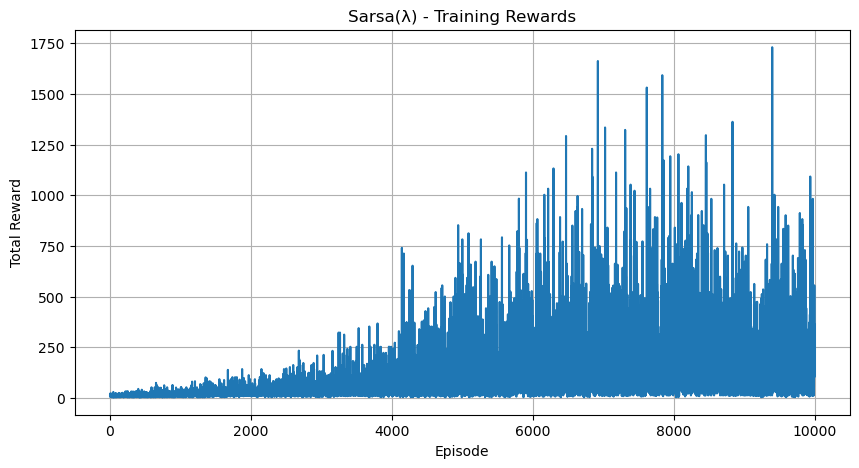

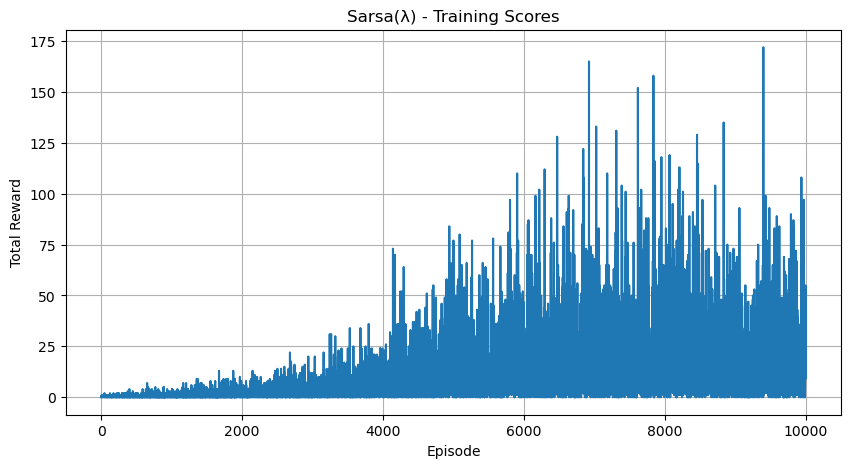

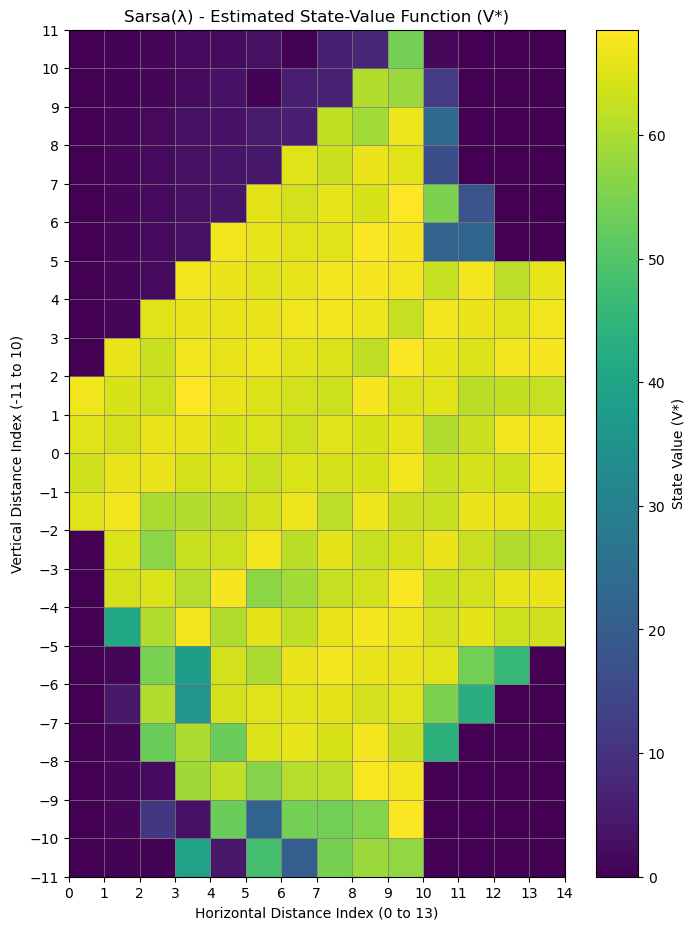

In [13]:
# Plot rewards and scores
plot_rewards(sarsa_rewards, title="Sarsa(λ) - Training Rewards")
plot_rewards(sarsa_scores, title="Sarsa(λ) - Training Scores")

# Plot State-Value Function
sarsa_V = plot_state_value_function(sarsa_Q, h_dist_space, v_dist_space, title="Sarsa(λ) - Estimated State-Value Function (V*)")


## 5. Evaluation and Comparison

Compare the performance of the two agents.

In [ ]:
def evaluate_agent(env, Q, num_episodes=100):
    """Evaluates a trained agent's performance using a greedy policy."""
    total_rewards = []
    total_scores = []
    action_space = env.action_space
    high_score_threshold = 1000 # Example threshold for high score
    n_high_score_achieved = 0

    for episode in tqdm(range(num_episodes)):
        observation, info = env.reset()
        done = False
        episode_reward = 0
        episode_score = 0
        while not done:
            state = get_state(observation) # Use new state function
            # Use greedy policy for evaluation (epsilon = 0)
            action = epsilon_greedy_policy(Q, state, 0.0, action_space)
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_score = info.get('score', 0)
            if episode_score > high_score_threshold:
                n_high_score_achieved += 1
                break # Stop if high score is achieved
            
        total_rewards.append(episode_reward)
        total_scores.append(episode_score)

    avg_reward = np.mean(total_rewards)
    avg_score = np.mean(total_scores)
    print(f"Evaluation over {num_episodes} episodes: Avg Reward={avg_reward:.2f}, Avg Score={avg_score:.2f}")
    print(f"Number of episodes with high score (> {high_score_threshold}): {n_high_score_achieved}")
    
    # Plotting the distribution of scores
    plt.figure(figsize=(10, 5))
    plt.hist(total_scores, bins=20, color='blue', alpha=0.7)
    plt.title("Distribution of Scores from Evaluation")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.axvline(avg_score, color='red', linestyle='dashed', linewidth=1, label=f'Avg Score: {avg_score:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return avg_reward, avg_score

--- Evaluating Monte Carlo Agent ---


100%|██████████| 100/100 [00:00<00:00, 1051.46it/s]

Evaluation over 100 episodes: Avg Reward=73.47, Avg Score=6.17
Number of episodes with high score (> 1000): 0


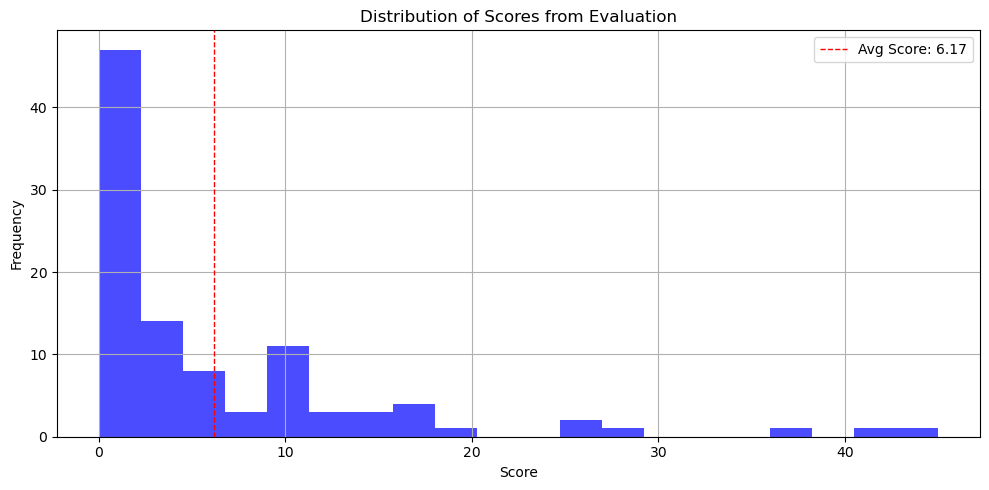


--- Evaluating Sarsa(Lambda) Agent ---


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Evaluation over 100 episodes: Avg Reward=10014.00, Avg Score=1001.00
Number of episodes with high score (> 1000): 100


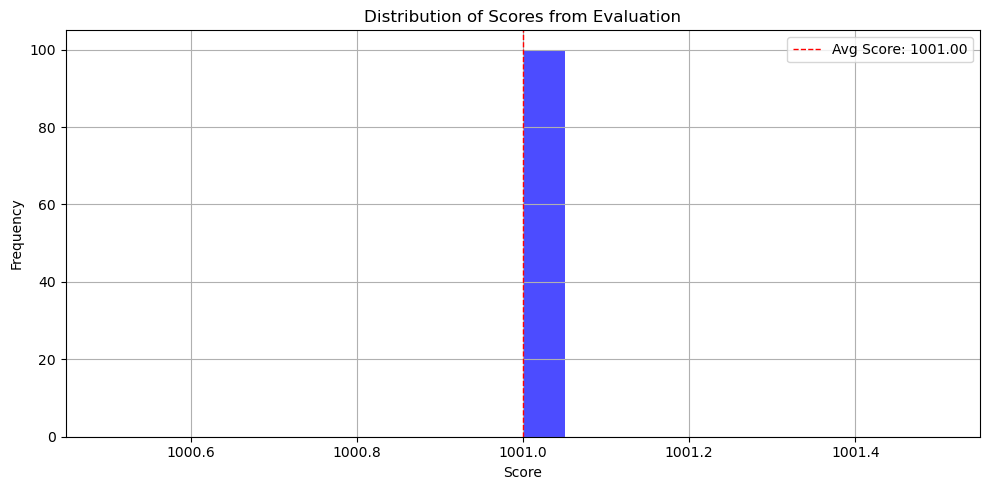

In [35]:
# --- Evaluate Trained Agents ---
print("--- Evaluating Monte Carlo Agent ---")
mc_eval_reward, mc_eval_score = evaluate_agent(env, mc_Q, num_episodes=100)

print("\n--- Evaluating Sarsa(Lambda) Agent ---")
sarsa_eval_reward, sarsa_eval_score = evaluate_agent(env, sarsa_Q, num_episodes=100)


### 5.1. Performance Comparison Plots

Plot learning curves (rewards/scores over episodes) for both agents on the same graph. Use moving averages for smoother curves.


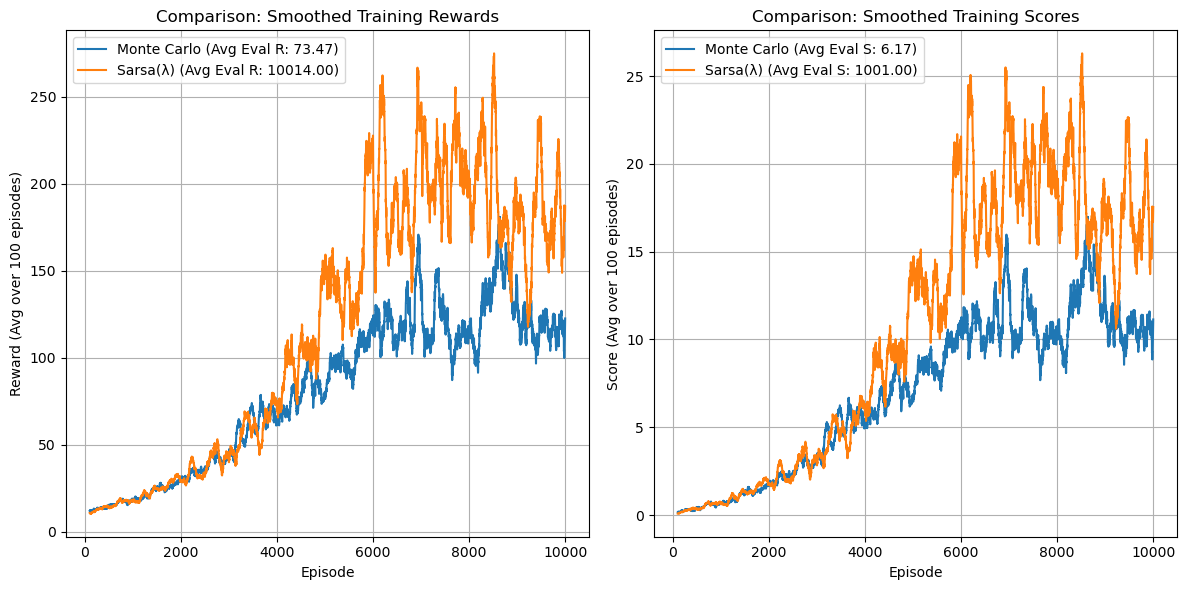

In [37]:
def moving_average(data, window_size):
    """Calculates the moving average of a list or array."""
    if len(data) < window_size:
        return np.array([]) # Return empty if not enough data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 100 # Moving average window size

# Ensure enough data points for moving average
mc_rewards_smooth = moving_average(mc_rewards, window)
sarsa_rewards_smooth = moving_average(sarsa_rewards, window)
mc_scores_smooth = moving_average(mc_scores, window)
sarsa_scores_smooth = moving_average(sarsa_scores, window)

# Adjust episode axis for smoothed data
if len(mc_rewards) >= window:
     episodes_axis_smooth = np.arange(window -1, len(mc_rewards)) # Use actual length
else:
     episodes_axis_smooth = np.array([])


plt.figure(figsize=(12, 6))

# Check if smoothed data exists before plotting
if episodes_axis_smooth.any():
    # Plot Rewards
    plt.subplot(1, 2, 1)
    plt.plot(episodes_axis_smooth, mc_rewards_smooth, label=f'Monte Carlo (Avg Eval R: {mc_eval_reward:.2f})')
    plt.plot(episodes_axis_smooth, sarsa_rewards_smooth, label=f'Sarsa(λ) (Avg Eval R: {sarsa_eval_reward:.2f})')
    plt.title('Comparison: Smoothed Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel(f'Reward (Avg over {window} episodes)')
    plt.legend()
    plt.grid(True)

    # Plot Scores
    plt.subplot(1, 2, 2)
    plt.plot(episodes_axis_smooth, mc_scores_smooth, label=f'Monte Carlo (Avg Eval S: {mc_eval_score:.2f})')
    plt.plot(episodes_axis_smooth, sarsa_scores_smooth, label=f'Sarsa(λ) (Avg Eval S: {sarsa_eval_score:.2f})')
    plt.title('Comparison: Smoothed Training Scores')
    plt.xlabel('Episode')
    plt.ylabel(f'Score (Avg over {window} episodes)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough episodes ({len(mc_rewards)}) to calculate moving average with window size {window}.")

### 5: Evaluation Run Analysis

The evaluation phase tests the agents' learned policies by running them greedily (epsilon=0) for 100 episodes without further learning.

* **Monte Carlo Evaluation:**
    * The agent achieved a very low average score of **6.17** over 100 episodes.
    * It failed to reach the high score threshold (> 1000) in **any** of the evaluation episodes.
    * This poor performance aligns with the low average scores observed during its training run and confirms findings from the parameter sweep, where the default epsilon decay used here was likely suboptimal compared to slower decays (like 0.9998 which achieved high scores) as we will be able to see in the following part.

* **Sarsa(λ) Evaluation (trained with α=0.1, λ=0.9):**
    * The agent performed exceptionally well, achieving an average score of **1001.00**.
    * It successfully reached the high score threshold (> 1000) in **all 100** evaluation episodes.
    * This excellent performance validates the effectiveness of the learned policy, even though the average score during the *training* phase was only 17.54. The discrepancy highlights the impact of exploration during training versus pure exploitation during evaluation.

**Comparison and Conclusion from Evaluation:**

Based on the evaluation results with these specific hyperparameters:

1.  **Sarsa(λ) significantly outperformed Monte Carlo.** Sarsa(λ) consistently achieved the target high score, while Monte Carlo performed poorly.
2.  The results demonstrate the importance of hyperparameter tuning. The chosen parameters for Sarsa(λ) (α=0.1, λ=0.9) proved highly effective, aligning with the findings from the dedicated parameter sweeps. Conversely, the parameters used for the main Monte Carlo training run were likely insufficient for it to learn the optimal policy within 10,000 episodes, although the sweeps showed MC *could* perform well with different parameters (specifically, slower epsilon decay).
3.  The evaluation confirms that Sarsa(λ), with appropriate parameters, is a more effective algorithm for learning a high-performing policy in this Text Flappy Bird environment compared to the Monte Carlo implementation tested here within the same number of training episodes.

## 6 Parameter Sweep

Perform a parameter sweep for both agents. To understand the sensitivity of our agents to hyperparameters, we run training multiple times with different parameter values. We'll use fewer episodes for sweeps to make it computationally feasible.


--- Starting Monte Carlo Epsilon Decay Sweep ---


Training MC: 100%|██████████| 3000/3000 [00:16<00:00, 177.99ep/s, Avg R (100)=128.04, Avg S (100)=11.69, Epsilon=0.050, Steps=103]


Monte Carlo training finished. Final Avg Score (last 100 ep): 11.69


100%|██████████| 200/200 [00:07<00:00, 27.44it/s]

Evaluation over 200 episodes: Avg Reward=2944.16, Avg Score=293.65
Number of episodes with high score (> 1000): 9


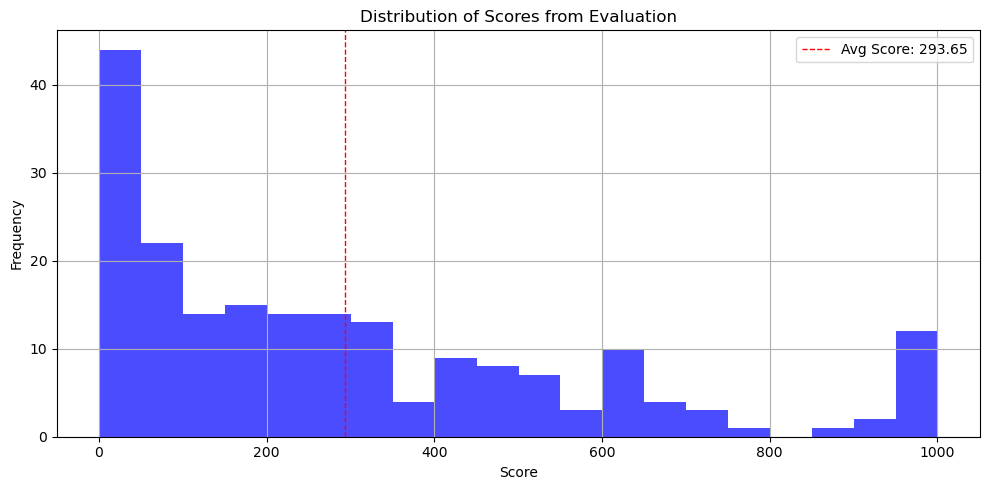

MC Epsilon Sweep:  25%|██▌       | 1/4 [00:24<01:13, 24.34s/decay_val, Current Decay=0.9950]

  Evaluation for decay=0.9900: Avg Score=293.65


Training MC: 100%|██████████| 3000/3000 [00:15<00:00, 189.43ep/s, Avg R (100)=115.38, Avg S (100)=10.37, Epsilon=0.050, Steps=23]


Monte Carlo training finished. Final Avg Score (last 100 ep): 10.37


100%|██████████| 200/200 [00:00<00:00, 681.53it/s]


Evaluation over 200 episodes: Avg Reward=102.46, Avg Score=9.15
Number of episodes with high score (> 1000): 0


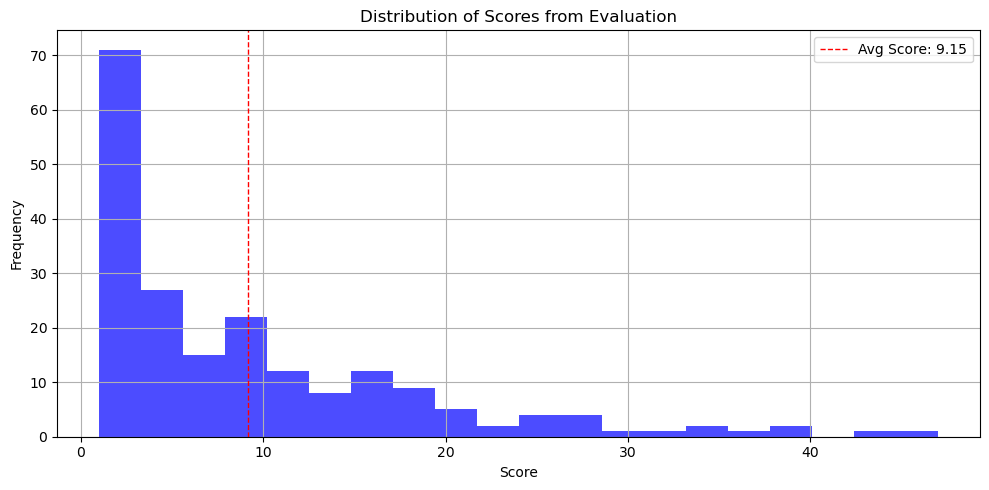

MC Epsilon Sweep:  50%|█████     | 2/4 [00:40<00:39, 19.67s/decay_val, Current Decay=0.9990]

  Evaluation for decay=0.9950: Avg Score=9.15


Training MC: 100%|██████████| 3000/3000 [00:09<00:00, 331.03ep/s, Avg R (100)=141.39, Avg S (100)=12.97, Epsilon=0.050, Steps=73]


Monte Carlo training finished. Final Avg Score (last 100 ep): 12.97


100%|██████████| 200/200 [00:01<00:00, 172.67it/s]


Evaluation over 200 episodes: Avg Reward=475.07, Avg Score=46.63
Number of episodes with high score (> 1000): 0


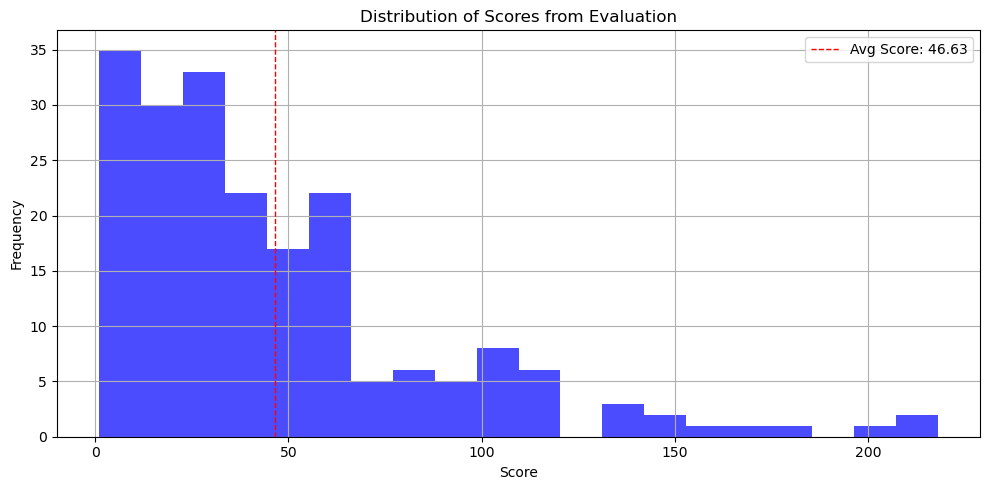

MC Epsilon Sweep:  75%|███████▌  | 3/4 [00:51<00:15, 15.45s/decay_val, Current Decay=0.9998]

  Evaluation for decay=0.9990: Avg Score=46.63


Training MC: 100%|██████████| 3000/3000 [00:03<00:00, 962.56ep/s, Avg R (100)=20.72, Avg S (100)=0.88, Epsilon=0.549, Steps=43]


Monte Carlo training finished. Final Avg Score (last 100 ep): 0.88


100%|██████████| 200/200 [00:25<00:00,  7.88it/s]


Evaluation over 200 episodes: Avg Reward=10014.00, Avg Score=1001.00
Number of episodes with high score (> 1000): 200


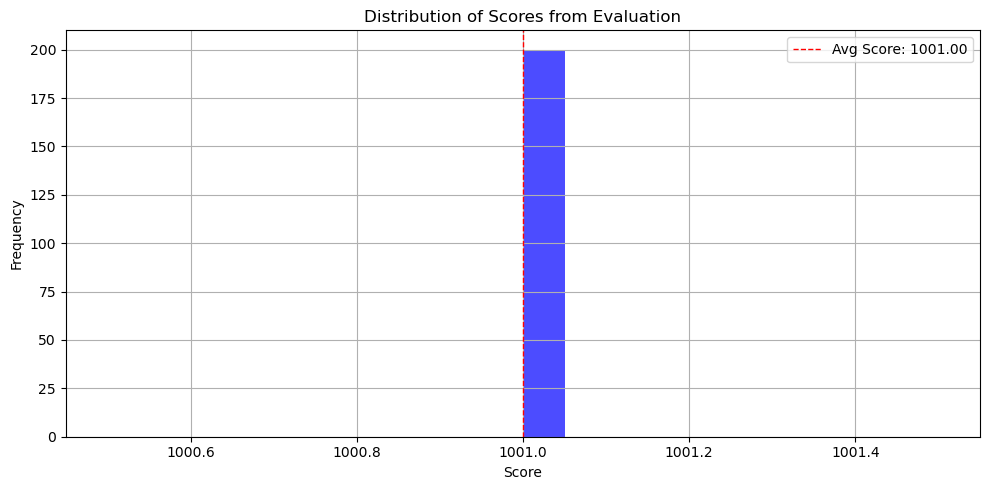

MC Epsilon Sweep: 100%|██████████| 4/4 [01:19<00:00, 19.98s/decay_val, Current Decay=0.9998]


  Evaluation for decay=0.9998: Avg Score=1001.00
--- Monte Carlo Epsilon Decay Sweep Finished ---

--- Starting Sarsa(λ) Alpha Sweep ---


Training Sarsa(λ α=0.01, λ=0.9): 100%|██████████| 3000/3000 [00:02<00:00, 1215.00ep/s, Avg R (100)=38.27, Avg S (100)=2.67, Epsilon=0.223, Steps=33, Traces=33]


Sarsa(Lambda α=0.01, λ=0.9) training finished. Final Avg Score (last 100 ep): 2.67


100%|██████████| 200/200 [00:01<00:00, 147.51it/s]


Evaluation over 200 episodes: Avg Reward=543.63, Avg Score=53.38
Number of episodes with high score (> 1000): 0


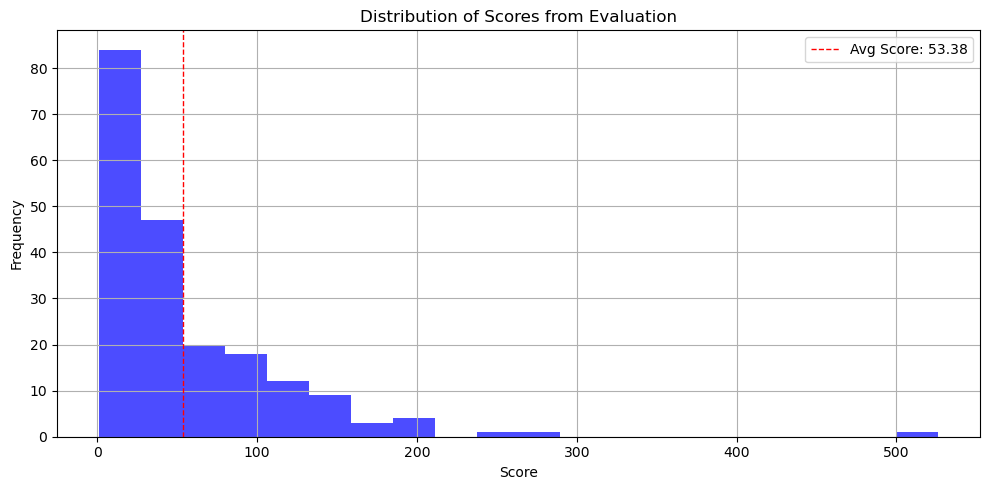

Sarsa Alpha Sweep:  20%|██        | 1/5 [00:04<00:16,  4.08s/alpha_val, Current Alpha=0.05]

  Evaluation for alpha=0.01: Avg Score=53.38


Training Sarsa(λ α=0.05, λ=0.9): 100%|██████████| 3000/3000 [00:03<00:00, 886.77ep/s, Avg R (100)=48.16, Avg S (100)=3.61, Epsilon=0.223, Steps=13, Traces=13]


Sarsa(Lambda α=0.05, λ=0.9) training finished. Final Avg Score (last 100 ep): 3.61


100%|██████████| 200/200 [00:02<00:00, 74.48it/s]


Evaluation over 200 episodes: Avg Reward=1049.80, Avg Score=104.17
Number of episodes with high score (> 1000): 0


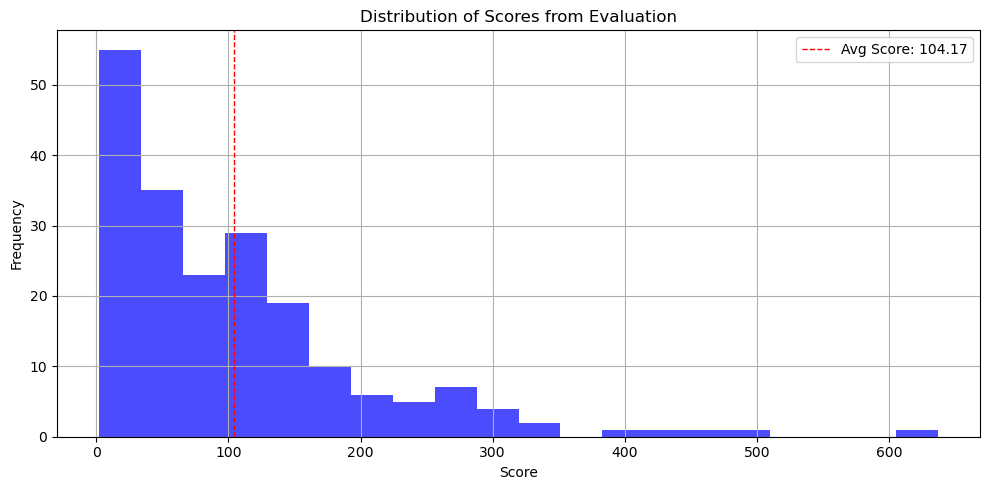

Sarsa Alpha Sweep:  40%|████      | 2/5 [00:10<00:16,  5.39s/alpha_val, Current Alpha=0.10]

  Evaluation for alpha=0.05: Avg Score=104.17


Training Sarsa(λ α=0.1, λ=0.9): 100%|██████████| 3000/3000 [00:03<00:00, 954.60ep/s, Avg R (100)=44.21, Avg S (100)=3.24, Epsilon=0.223, Steps=63, Traces=50]


Sarsa(Lambda α=0.1, λ=0.9) training finished. Final Avg Score (last 100 ep): 3.24


100%|██████████| 200/200 [00:01<00:00, 115.19it/s]


Evaluation over 200 episodes: Avg Reward=720.52, Avg Score=70.97
Number of episodes with high score (> 1000): 0


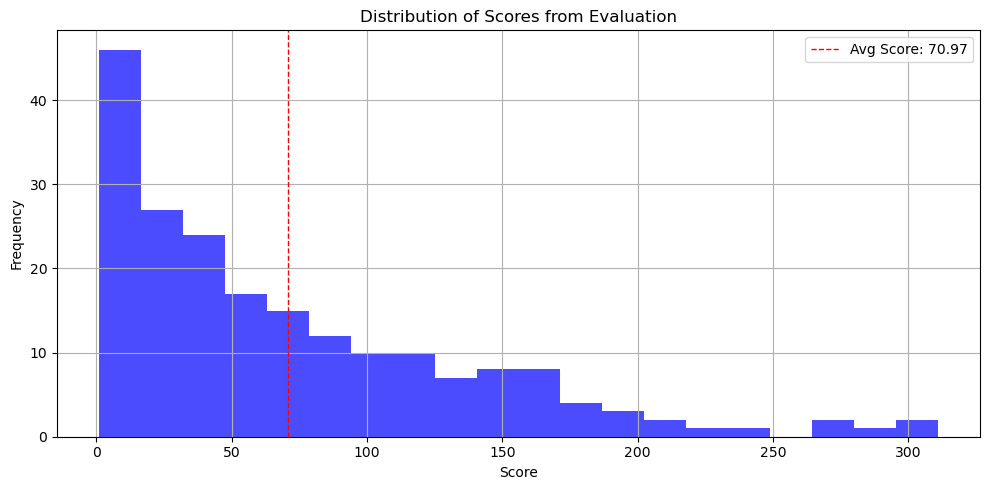

Sarsa Alpha Sweep:  60%|██████    | 3/5 [00:15<00:10,  5.25s/alpha_val, Current Alpha=0.20]

  Evaluation for alpha=0.10: Avg Score=70.97


Training Sarsa(λ α=0.2, λ=0.9): 100%|██████████| 3000/3000 [00:02<00:00, 1092.79ep/s, Avg R (100)=48.00, Avg S (100)=3.66, Epsilon=0.223, Steps=39, Traces=33]


Sarsa(Lambda α=0.2, λ=0.9) training finished. Final Avg Score (last 100 ep): 3.66


100%|██████████| 200/200 [00:00<00:00, 529.74it/s]


Evaluation over 200 episodes: Avg Reward=146.60, Avg Score=13.66
Number of episodes with high score (> 1000): 0


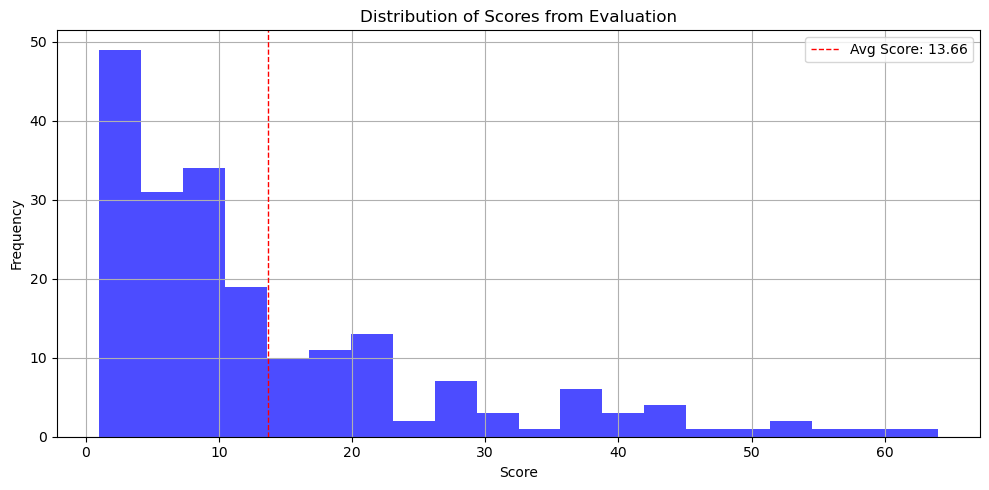

Sarsa Alpha Sweep:  80%|████████  | 4/5 [00:18<00:04,  4.49s/alpha_val, Current Alpha=0.40]

  Evaluation for alpha=0.20: Avg Score=13.66


Training Sarsa(λ α=0.4, λ=0.9): 100%|██████████| 3000/3000 [00:02<00:00, 1277.09ep/s, Avg R (100)=35.66, Avg S (100)=2.39, Epsilon=0.223, Steps=23, Traces=20]


Sarsa(Lambda α=0.4, λ=0.9) training finished. Final Avg Score (last 100 ep): 2.39


100%|██████████| 200/200 [00:00<00:00, 326.99it/s]


Evaluation over 200 episodes: Avg Reward=227.77, Avg Score=21.68
Number of episodes with high score (> 1000): 0


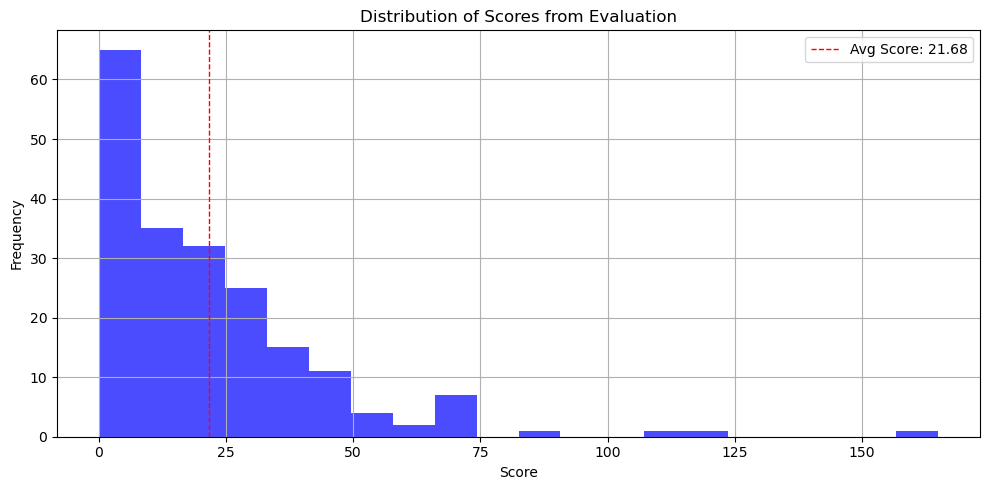

Sarsa Alpha Sweep: 100%|██████████| 5/5 [00:21<00:00,  4.39s/alpha_val, Current Alpha=0.40]


  Evaluation for alpha=0.40: Avg Score=21.68
--- Sarsa(λ) Alpha Sweep Finished ---

--- Starting Sarsa(λ) Lambda Sweep ---


Training Sarsa(λ α=0.1, λ=0.0): 100%|██████████| 3000/3000 [00:03<00:00, 963.89ep/s, Avg R (100)=47.28, Avg S (100)=3.61, Epsilon=0.223, Steps=32, Traces=25]


Sarsa(Lambda α=0.1, λ=0.0) training finished. Final Avg Score (last 100 ep): 3.61


100%|██████████| 200/200 [00:22<00:00,  8.99it/s]


Evaluation over 200 episodes: Avg Reward=9138.28, Avg Score=913.37
Number of episodes with high score (> 1000): 182


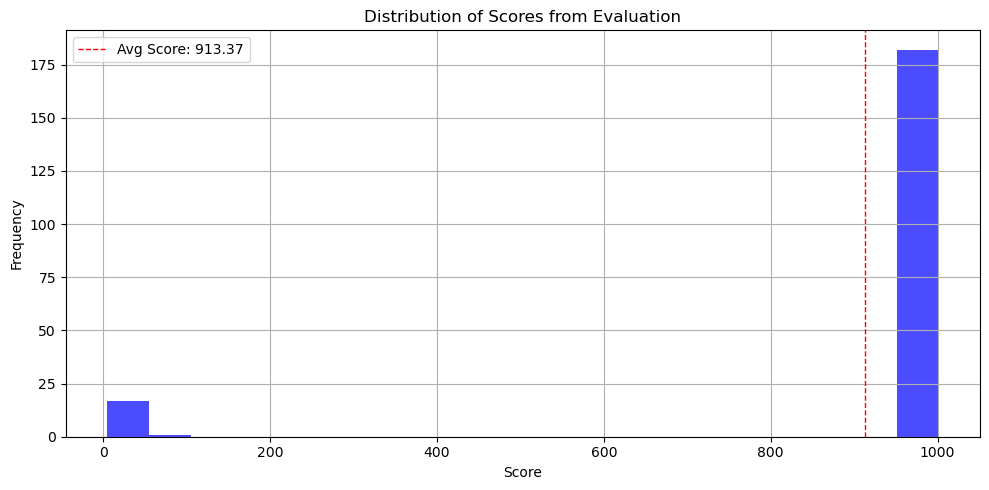

Sarsa Lambda Sweep:  17%|█▋        | 1/6 [00:25<02:07, 25.57s/lambda_val, Current Lambda=0.50]

  Evaluation for lambda=0.00: Avg Score=913.37


Training Sarsa(λ α=0.1, λ=0.5): 100%|██████████| 3000/3000 [00:03<00:00, 932.90ep/s, Avg R (100)=46.56, Avg S (100)=3.53, Epsilon=0.223, Steps=23, Traces=23]


Sarsa(Lambda α=0.1, λ=0.5) training finished. Final Avg Score (last 100 ep): 3.53


100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


Evaluation over 200 episodes: Avg Reward=10014.00, Avg Score=1001.00
Number of episodes with high score (> 1000): 200


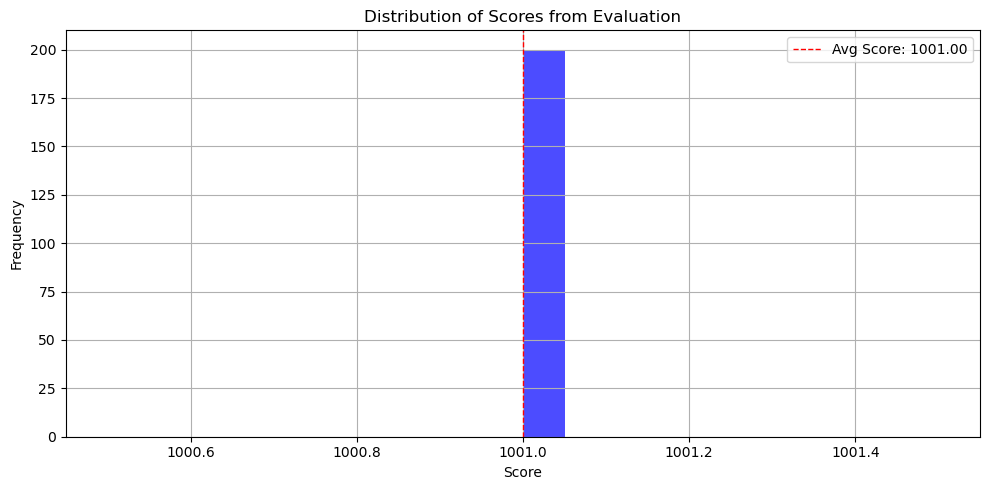

Sarsa Lambda Sweep:  33%|███▎      | 2/6 [00:53<01:48, 27.15s/lambda_val, Current Lambda=0.80]

  Evaluation for lambda=0.50: Avg Score=1001.00


Training Sarsa(λ α=0.1, λ=0.8): 100%|██████████| 3000/3000 [00:03<00:00, 937.30ep/s, Avg R (100)=49.61, Avg S (100)=3.75, Epsilon=0.223, Steps=33, Traces=30]


Sarsa(Lambda α=0.1, λ=0.8) training finished. Final Avg Score (last 100 ep): 3.75


100%|██████████| 200/200 [00:01<00:00, 162.35it/s]


Evaluation over 200 episodes: Avg Reward=511.95, Avg Score=50.38
Number of episodes with high score (> 1000): 0


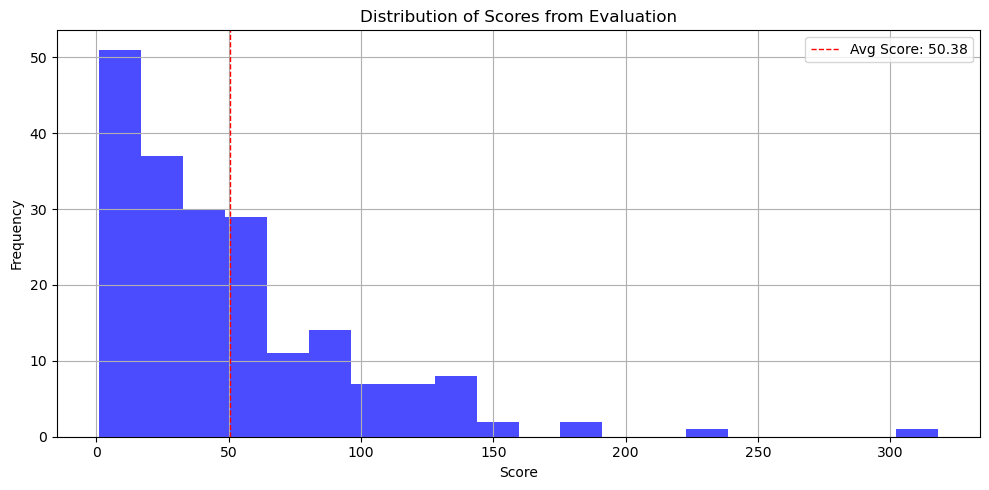

Sarsa Lambda Sweep:  50%|█████     | 3/6 [00:58<00:50, 16.87s/lambda_val, Current Lambda=0.90]

  Evaluation for lambda=0.80: Avg Score=50.38


Training Sarsa(λ α=0.1, λ=0.9): 100%|██████████| 3000/3000 [00:03<00:00, 944.47ep/s, Avg R (100)=47.61, Avg S (100)=3.59, Epsilon=0.223, Steps=153, Traces=77]


Sarsa(Lambda α=0.1, λ=0.9) training finished. Final Avg Score (last 100 ep): 3.59


100%|██████████| 200/200 [00:24<00:00,  8.12it/s]


Evaluation over 200 episodes: Avg Reward=10014.00, Avg Score=1001.00
Number of episodes with high score (> 1000): 200


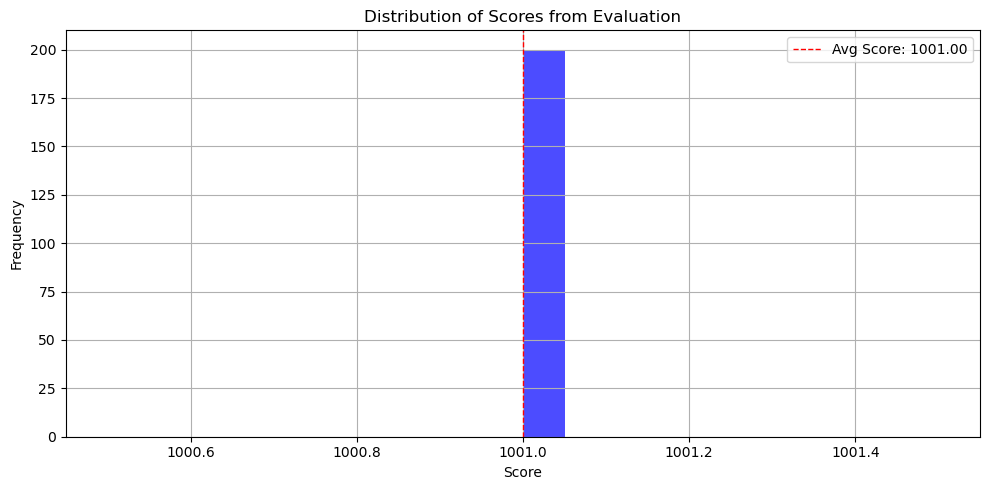

Sarsa Lambda Sweep:  67%|██████▋   | 4/6 [01:26<00:42, 21.28s/lambda_val, Current Lambda=0.95]

  Evaluation for lambda=0.90: Avg Score=1001.00


Training Sarsa(λ α=0.1, λ=0.95): 100%|██████████| 3000/3000 [00:03<00:00, 980.41ep/s, Avg R (100)=42.84, Avg S (100)=3.13, Epsilon=0.223, Steps=53, Traces=39]


Sarsa(Lambda α=0.1, λ=0.95) training finished. Final Avg Score (last 100 ep): 3.13


100%|██████████| 200/200 [00:19<00:00, 10.16it/s]

Evaluation over 200 episodes: Avg Reward=8159.88, Avg Score=815.55
Number of episodes with high score (> 1000): 125


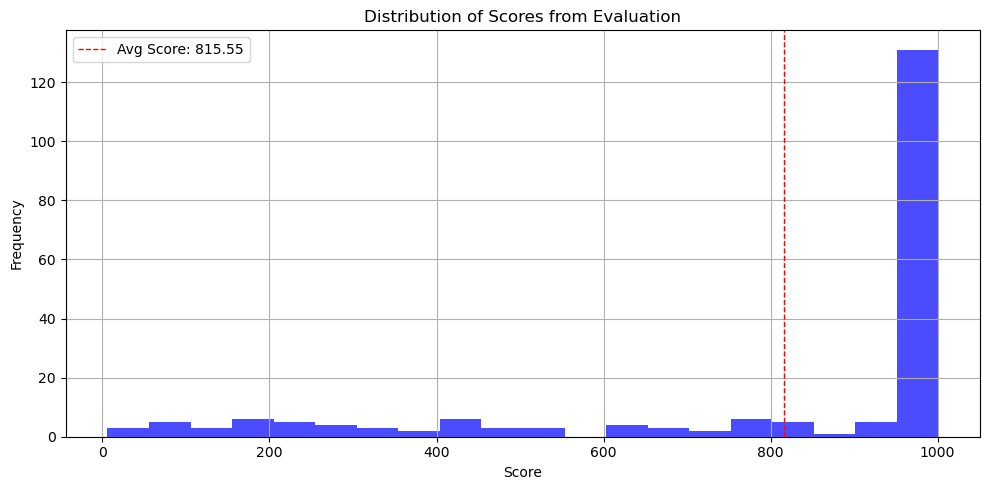

Sarsa Lambda Sweep:  83%|████████▎ | 5/6 [01:49<00:21, 21.88s/lambda_val, Current Lambda=1.00]

  Evaluation for lambda=0.95: Avg Score=815.55


Training Sarsa(λ α=0.1, λ=1.0): 100%|██████████| 3000/3000 [00:02<00:00, 1205.01ep/s, Avg R (100)=34.58, Avg S (100)=2.32, Epsilon=0.223, Steps=33, Traces=33]


Sarsa(Lambda α=0.1, λ=1.0) training finished. Final Avg Score (last 100 ep): 2.32


100%|██████████| 200/200 [00:00<00:00, 727.77it/s]


Evaluation over 200 episodes: Avg Reward=99.48, Avg Score=9.10
Number of episodes with high score (> 1000): 0


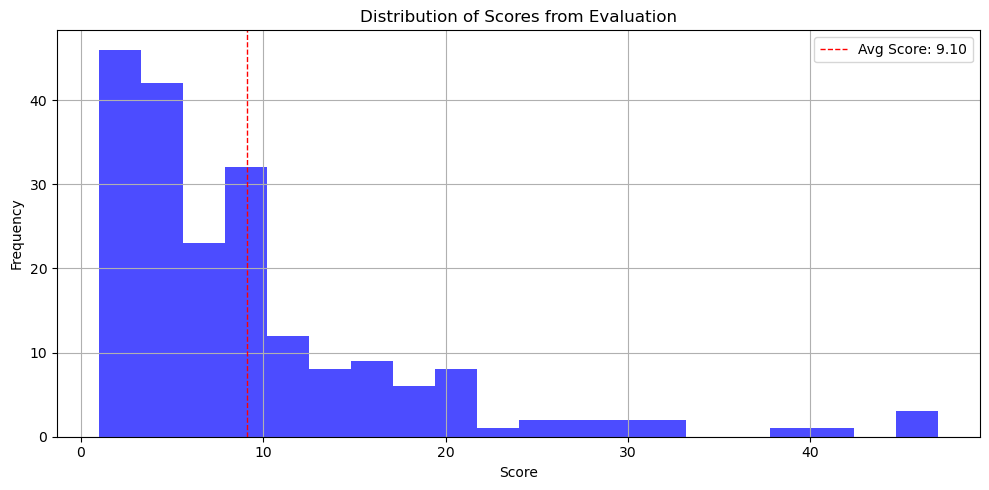

Sarsa Lambda Sweep: 100%|██████████| 6/6 [01:52<00:00, 18.73s/lambda_val, Current Lambda=1.00]

  Evaluation for lambda=1.00: Avg Score=9.10
--- Sarsa(λ) Lambda Sweep Finished ---


In [ ]:
# --- Parameters for Sweeps ---
sweep_episodes = 3000
eval_episodes = 200

# --- Monte Carlo Sweep (Epsilon Decay) ---

mc_epsilon_decays_to_test = [0.99, 0.995, 0.999, 0.9998]
mc_sweep_results = {}

print("--- Starting Monte Carlo Epsilon Decay Sweep ---")
# Wrap the outer sweep loop with tqdm
sweep_pbar_mc = tqdm(mc_epsilon_decays_to_test, desc="MC Epsilon Sweep", unit="decay_val")
for decay in sweep_pbar_mc:
    sweep_pbar_mc.set_postfix({"Current Decay": f"{decay:.4f}"}) # Show current value
    # The run_monte_carlo function now has its own internal tqdm bar for episodes
    # Set leave=False for the inner bar if you don't want it to persist after completion
    # (This is handled inside run_monte_carlo if modified as above, default leave=True is usually fine)
    Q, rewards, scores = run_monte_carlo(env,
                                         num_episodes=sweep_episodes,
                                         gamma=mc_gamma,
                                         epsilon_start=mc_epsilon_start,
                                         epsilon_decay=decay,
                                         epsilon_min=mc_epsilon_min)

    # Evaluation does not need a progress bar unless it takes very long
    avg_eval_reward, avg_eval_score = evaluate_agent(env, Q, num_episodes=eval_episodes)
    print(f"  Evaluation for decay={decay:.4f}: Avg Score={avg_eval_score:.2f}")

    mc_sweep_results[decay] = {
        'avg_reward': avg_eval_reward,
        'avg_score': avg_eval_score,
        'rewards_curve': rewards,
        'scores_curve': scores
    }
sweep_pbar_mc.close()
print("--- Monte Carlo Epsilon Decay Sweep Finished ---")


# --- Sarsa(λ) Sweep (Alpha - Learning Rate) ---

sarsa_alphas_to_test = [0.01, 0.05, 0.1, 0.2, 0.4]
sarsa_alpha_sweep_results = {}

print("\n--- Starting Sarsa(λ) Alpha Sweep ---")
# Wrap the outer sweep loop with tqdm
sweep_pbar_sarsa_alpha = tqdm(sarsa_alphas_to_test, desc="Sarsa Alpha Sweep", unit="alpha_val")
for alpha in sweep_pbar_sarsa_alpha:
    sweep_pbar_sarsa_alpha.set_postfix({"Current Alpha": f"{alpha:.2f}"})
    # Inner tqdm bar for episodes is handled by run_sarsa_lambda
    Q, rewards, scores = run_sarsa_lambda(env,
                                          num_episodes=sweep_episodes,
                                          alpha=alpha,
                                          gamma=sarsa_gamma,
                                          lambda_trace=sarsa_lambda, # Use default lambda
                                          epsilon_start=sarsa_epsilon_start,
                                          epsilon_decay=sarsa_epsilon_decay,
                                          epsilon_min=sarsa_epsilon_min)

    avg_eval_reward, avg_eval_score = evaluate_agent(env, Q, num_episodes=eval_episodes)
    print(f"  Evaluation for alpha={alpha:.2f}: Avg Score={avg_eval_score:.2f}")

    sarsa_alpha_sweep_results[alpha] = {
        'avg_reward': avg_eval_reward,
        'avg_score': avg_eval_score,
        'rewards_curve': rewards,
        'scores_curve': scores
    }
sweep_pbar_sarsa_alpha.close()
print("--- Sarsa(λ) Alpha Sweep Finished ---")


# --- Sarsa(λ) Sweep (Lambda - Trace Decay) ---

sarsa_lambdas_to_test = [0.0, 0.5, 0.8, 0.9, 0.95, 1.0]
sarsa_lambda_sweep_results = {}

print("\n--- Starting Sarsa(λ) Lambda Sweep ---")
# Wrap the outer sweep loop with tqdm
sweep_pbar_sarsa_lambda = tqdm(sarsa_lambdas_to_test, desc="Sarsa Lambda Sweep", unit="lambda_val")
for lambda_val in sweep_pbar_sarsa_lambda:
    sweep_pbar_sarsa_lambda.set_postfix({"Current Lambda": f"{lambda_val:.2f}"})
    # Inner tqdm bar for episodes is handled by run_sarsa_lambda
    Q, rewards, scores = run_sarsa_lambda(env,
                                          num_episodes=sweep_episodes,
                                          alpha=sarsa_alpha, # Use default alpha
                                          gamma=sarsa_gamma,
                                          lambda_trace=lambda_val,
                                          epsilon_start=sarsa_epsilon_start,
                                          epsilon_decay=sarsa_epsilon_decay,
                                          epsilon_min=sarsa_epsilon_min)

    avg_eval_reward, avg_eval_score = evaluate_agent(env, Q, num_episodes=eval_episodes)
    print(f"  Evaluation for lambda={lambda_val:.2f}: Avg Score={avg_eval_score:.2f}")

    sarsa_lambda_sweep_results[lambda_val] = {
        'avg_reward': avg_eval_reward,
        'avg_score': avg_eval_score,
        'rewards_curve': rewards,
        'scores_curve': scores
    }
sweep_pbar_sarsa_lambda.close()
print("--- Sarsa(λ) Lambda Sweep Finished ---")

### Parameter Sweep Analysis

To better understand how hyperparameter choices influence agent performance, we conducted systematic sweeps for key parameters in both the Monte Carlo (MC) and Sarsa(λ) algorithms, using a reduced number of training episodes (3000) for feasibility.

**Monte Carlo: Epsilon Decay Sensitivity**

The performance of the Monte Carlo agent demonstrated a **strong dependency** on the rate of epsilon decay. We observed that faster decay rates (e.g., 0.99, 0.995, 0.999) led to relatively poor final policies, with average evaluation scores remaining low (ranging from ~9 to ~294). In contrast, a significantly slower decay rate (`epsilon_decay=0.9998`) allowed the agent to achieve **near-perfect performance**, consistently reaching the high-score threshold (average score ~1001). This suggests that extended exploration is critical for the MC agent to discover an effective policy in this environment within the given training budget. Converging epsilon too quickly likely traps the agent in suboptimal solutions.

**Sarsa(λ): Learning Rate (Alpha) Sensitivity**

Investigating the learning rate (`alpha`) for Sarsa(λ) (while keeping `lambda=0.9`) revealed a non-linear relationship with performance. An intermediate value (`alpha=0.05`) yielded the best average score (~104) among the tested values [0.01, 0.05, 0.1, 0.2, 0.4]. Lower learning rates resulted in slower learning, while higher rates appeared to hinder performance, possibly due to unstable updates or overshooting optimal values. This highlights the classic trade-off in selecting an appropriate learning rate – it must be high enough to facilitate learning within a reasonable timeframe but low enough to allow for stable convergence.

**Sarsa(λ): Trace Decay (Lambda) Sensitivity**

The trace decay parameter (`lambda`), which controls the extent of credit assignment from eligibility traces, had a **profound impact** on Sarsa(λ)'s performance (tested with `alpha=0.1`).
* Interestingly, `lambda=0` (equivalent to standard Sarsa without eligibility traces) performed remarkably well, achieving a high average score (~913).
* Intermediate values of `lambda`, specifically `0.5` and `0.9`, resulted in **optimal performance**, consistently reaching the high-score threshold (average score ~1001). This indicates that incorporating eligibility traces, allowing updates to propagate back over recent state-action pairs, can significantly accelerate learning or lead to better policies compared to single-step updates in this environment, provided `lambda` is chosen well.
* However, not all trace lengths were beneficial; `lambda=0.8` performed poorly, and `lambda=1.0` (approximating Monte Carlo updates within the Sarsa framework) resulted in very low scores, performing worse than even `lambda=0`.

**Conclusions from Parameter Sweeps:**

These experiments underscore the **critical role of hyperparameter tuning** in achieving good performance with both Monte Carlo and Sarsa(λ) agents.
1.  **Sensitivity:** Both algorithms exhibited significant sensitivity, but to different parameters. MC was highly dependent on the exploration schedule (epsilon decay), while Sarsa(λ) showed strong sensitivity to both the learning rate (alpha) and, perhaps more dramatically, the trace decay factor (lambda).
2.  **Optimal Ranges:** Optimal performance often lies within specific ranges, and values outside these ranges can lead to substantially degraded results (e.g., Sarsa with high alpha or lambda=1.0, MC with fast epsilon decay).
3.  **Eligibility Traces:** For Sarsa(λ) in this environment, eligibility traces (with well-chosen intermediate `lambda` values like 0.5 or 0.9) proved highly effective, leading to the best observed performance. However, even standard Sarsa(0) significantly outperformed MC (with its default parameters) and Sarsa(1).

These findings emphasize that while algorithms provide the learning framework, their practical success hinges on careful configuration tailored to the specific problem and computational budget. The sweeps provide valuable guidance for selecting effective parameters for the final agent comparison.

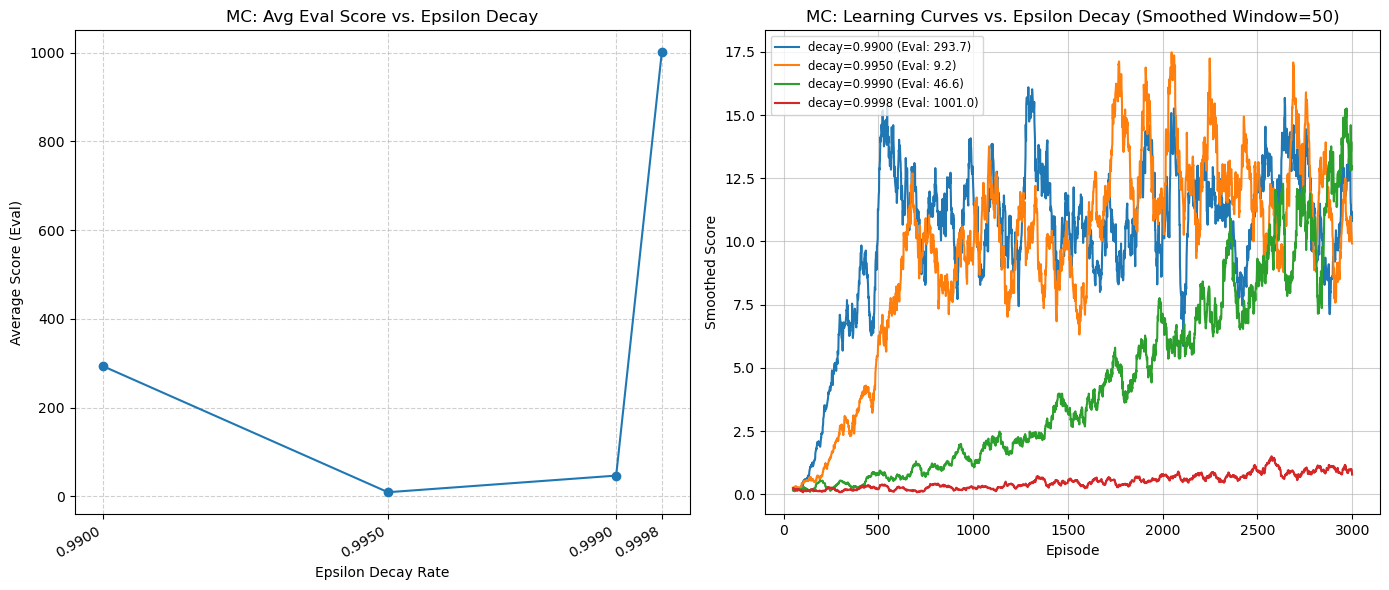

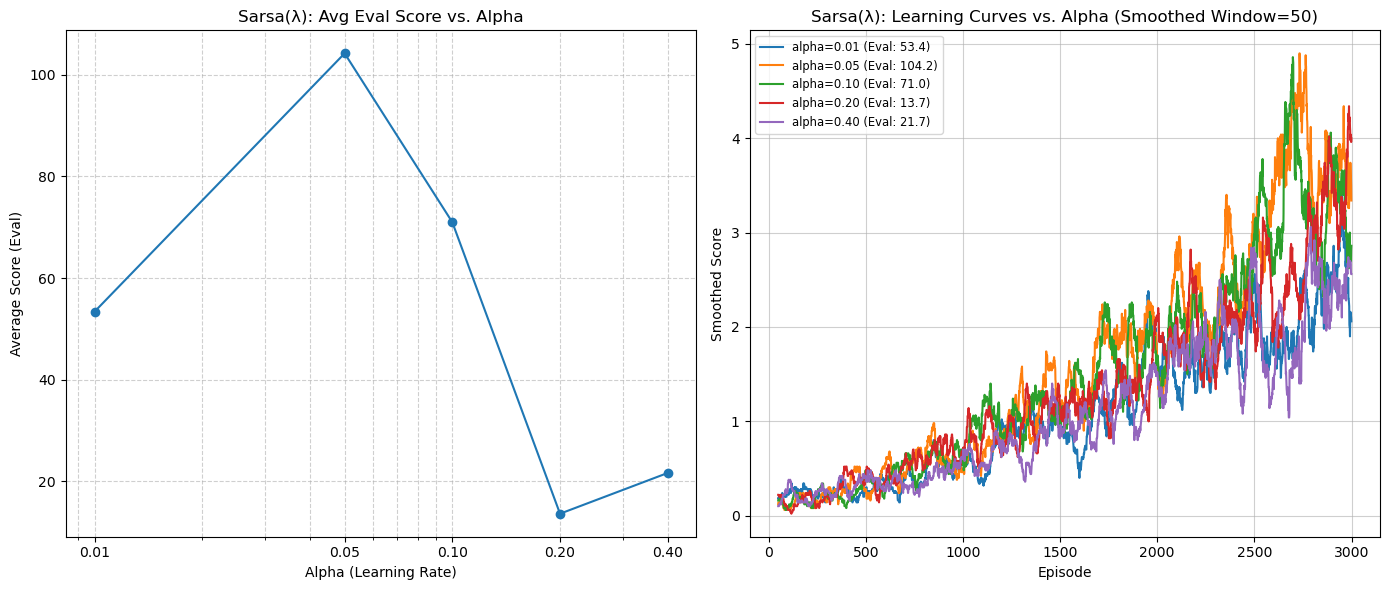

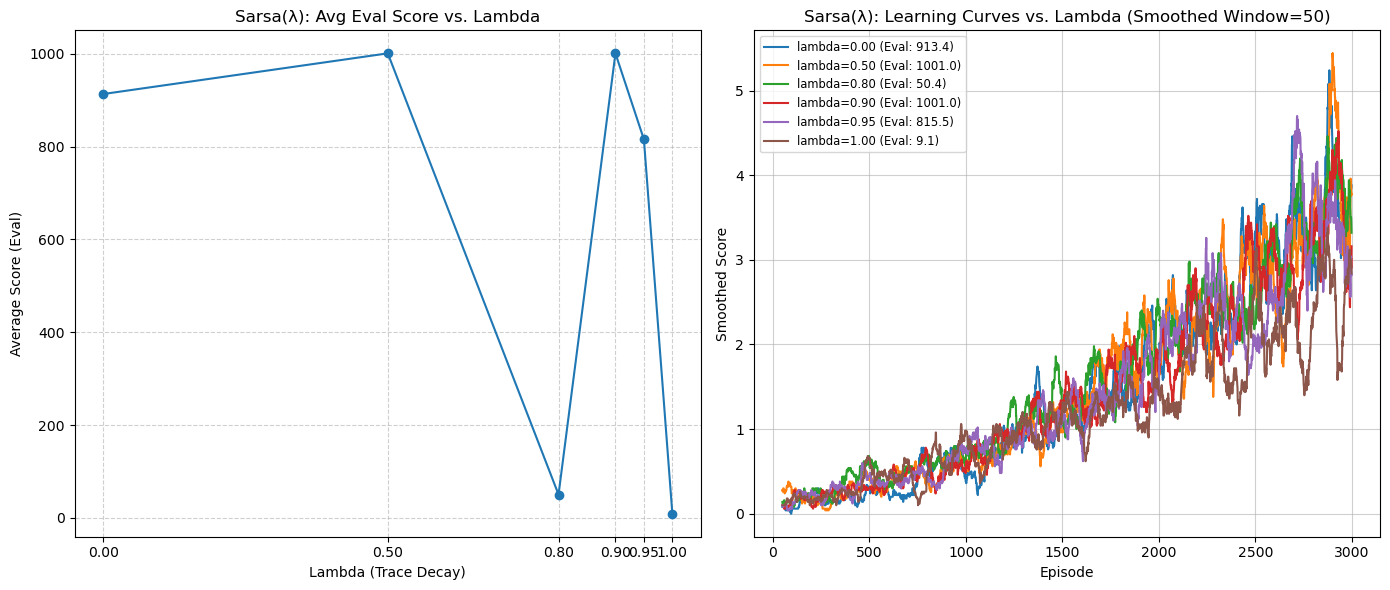

In [40]:
sweep_plot_window = 50

if 'mc_sweep_results' in locals() and mc_sweep_results:
    plt.figure(figsize=(14, 6))

    # Plot 1: Average Evaluation Score vs. Epsilon Decay
    plt.subplot(1, 2, 1)
    sorted_decays = sorted(mc_sweep_results.keys())
    eval_scores = [mc_sweep_results[decay]['avg_score'] for decay in sorted_decays]

    plt.plot(sorted_decays, eval_scores, marker='o', linestyle='-')
    plt.title('MC: Avg Eval Score vs. Epsilon Decay')
    plt.xlabel('Epsilon Decay Rate')
    plt.ylabel(f'Average Score (Eval)')
    # Use log scale if decay values span orders of magnitude or if theory suggests it
    # plt.xscale('log')
    # Format x-ticks to be readable
    plt.xticks(sorted_decays, labels=[f'{d:.4f}' for d in sorted_decays], rotation=30, ha='right')
    plt.grid(True, which="both", ls="--", alpha=0.6)

    # Plot 2: Smoothed Learning Curves
    plt.subplot(1, 2, 2)
    for decay in sorted_decays:
        results = mc_sweep_results[decay]
        # Check if scores_curve exists and is not empty
        if 'scores_curve' in results and results['scores_curve']:
            scores_smooth = moving_average(results['scores_curve'], sweep_plot_window)
            if scores_smooth.any():
                 # Adjust episode axis for smoothed data
                 episode_axis = np.arange(sweep_plot_window - 1, len(results['scores_curve']))
                 plt.plot(episode_axis, scores_smooth, label=f'decay={decay:.4f} (Eval: {results["avg_score"]:.1f})')
        else:
             print(f"Warning: No scores_curve found for MC decay={decay}")


    plt.title(f'MC: Learning Curves vs. Epsilon Decay (Smoothed Window={sweep_plot_window})')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, alpha=0.6)

    plt.tight_layout()
    plt.show()
else:
    print("MC sweep results dictionary ('mc_sweep_results') not found or empty.")


# --- Visualize Sarsa(λ) Alpha Sweep ---
if 'sarsa_alpha_sweep_results' in locals() and sarsa_alpha_sweep_results:
    plt.figure(figsize=(14, 6))

    # Plot 1: Average Evaluation Score vs. Alpha
    plt.subplot(1, 2, 1)
    sorted_alphas = sorted(sarsa_alpha_sweep_results.keys())
    eval_scores_alpha = [sarsa_alpha_sweep_results[alpha]['avg_score'] for alpha in sorted_alphas]

    plt.plot(sorted_alphas, eval_scores_alpha, marker='o', linestyle='-')
    plt.title('Sarsa(λ): Avg Eval Score vs. Alpha')
    plt.xlabel('Alpha (Learning Rate)')
    plt.ylabel(f'Average Score (Eval)')
    plt.xscale('log') # Often useful for learning rates
    plt.xticks(sorted_alphas, labels=[f'{a:.2f}' for a in sorted_alphas])
    plt.grid(True, which="both", ls="--", alpha=0.6)

    # Plot 2: Smoothed Learning Curves
    plt.subplot(1, 2, 2)
    for alpha in sorted_alphas:
        results = sarsa_alpha_sweep_results[alpha]
        if 'scores_curve' in results and results['scores_curve']:
             scores_smooth = moving_average(results['scores_curve'], sweep_plot_window)
             if scores_smooth.any():
                  episode_axis = np.arange(sweep_plot_window - 1, len(results['scores_curve']))
                  plt.plot(episode_axis, scores_smooth, label=f'alpha={alpha:.2f} (Eval: {results["avg_score"]:.1f})')
        else:
             print(f"Warning: No scores_curve found for Sarsa alpha={alpha}")

    plt.title(f'Sarsa(λ): Learning Curves vs. Alpha (Smoothed Window={sweep_plot_window})')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, alpha=0.6)

    plt.tight_layout()
    plt.show()
else:
    print("Sarsa(λ) alpha sweep results dictionary ('sarsa_alpha_sweep_results') not found or empty.")


# --- Visualize Sarsa(λ) Lambda Sweep ---
if 'sarsa_lambda_sweep_results' in locals() and sarsa_lambda_sweep_results:
    plt.figure(figsize=(14, 6))

    # Plot 1: Average Evaluation Score vs. Lambda
    plt.subplot(1, 2, 1)
    sorted_lambdas = sorted(sarsa_lambda_sweep_results.keys())
    eval_scores_lambda = [sarsa_lambda_sweep_results[lambda_val]['avg_score'] for lambda_val in sorted_lambdas]

    plt.plot(sorted_lambdas, eval_scores_lambda, marker='o', linestyle='-')
    plt.title('Sarsa(λ): Avg Eval Score vs. Lambda')
    plt.xlabel('Lambda (Trace Decay)')
    plt.ylabel(f'Average Score (Eval)')
    # Linear scale is usually fine for lambda [0, 1]
    plt.xticks(sorted_lambdas, labels=[f'{l:.2f}' for l in sorted_lambdas])
    plt.grid(True, which="both", ls="--", alpha=0.6)

    # Plot 2: Smoothed Learning Curves
    plt.subplot(1, 2, 2)
    for lambda_val in sorted_lambdas:
        results = sarsa_lambda_sweep_results[lambda_val]
        if 'scores_curve' in results and results['scores_curve']:
            scores_smooth = moving_average(results['scores_curve'], sweep_plot_window)
            if scores_smooth.any():
                 episode_axis = np.arange(sweep_plot_window - 1, len(results['scores_curve']))
                 plt.plot(episode_axis, scores_smooth, label=f'lambda={lambda_val:.2f} (Eval: {results["avg_score"]:.1f})')
        else:
             print(f"Warning: No scores_curve found for Sarsa lambda={lambda_val}")


    plt.title(f'Sarsa(λ): Learning Curves vs. Lambda (Smoothed Window={sweep_plot_window})')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, alpha=0.6)

    plt.tight_layout()
    plt.show()
else:
     print("Sarsa(λ) lambda sweep results dictionary ('sarsa_lambda_sweep_results') not found or empty.")